<a href="https://colab.research.google.com/github/HananAlenezi/plants/blob/main/Retraining_Code_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup & Initialization

In [ ]:
# Import necessary libraries for deep learning, data processing, optimization, and model handling
import torch
import numpy as np
import torchvision.models as models
from torchvision.datasets import ImageFolder
import os
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.utils.model_zoo as model_zoo
import time
import pandas as pd
import matplotlib.pyplot as plt



# Check if GPU is available and set the device
print("Is GPU available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define batch size for data loading
batch_size = 32


Is GPU available: True


## 2. Data Preprocessing

Loading and resizing images to (224, 224)...

Dataset preprocessing, balancing, and loading completed successfully.


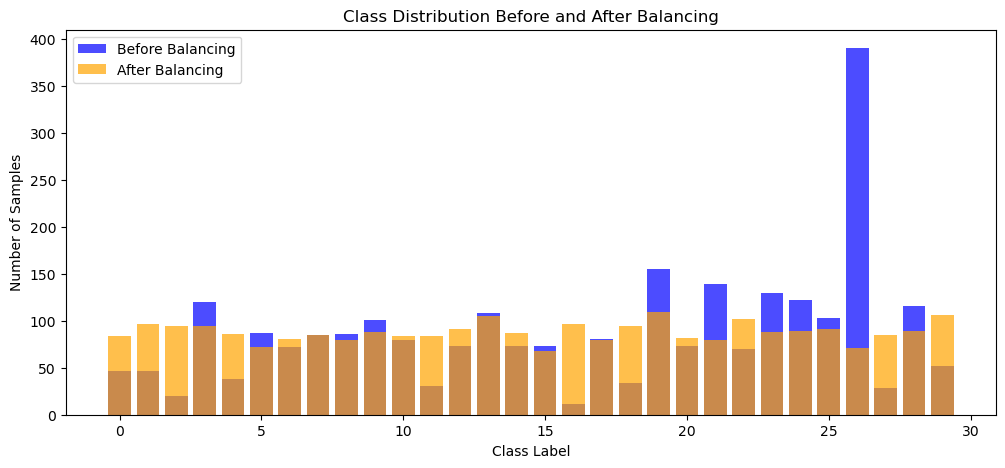

In [ ]:
# Define transformations for resizing, normalization, and conversion to tensor
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),            # Convert image to tensor
    transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])             # Normalize using the means and standard deviations of ImageNet dataset
])

# Function to load and preprocess train and test datasets
def load_resized_data(data_dir):
    print("Loading and resizing images to (224, 224)...")
    datasets_resized = {x: ImageFolder(os.path.join(data_dir, x), transform=common_transform) for x in ['train', 'test']}
    loaders = {
        'train': DataLoader(datasets_resized['train'], batch_size=batch_size, shuffle=True, num_workers=2),
        'test': DataLoader(datasets_resized['test'], batch_size=batch_size, shuffle=False, num_workers=2)
    }
    return loaders['train'], loaders['test'], datasets_resized['train']

# Compute class weights to handle imbalanced datasets
def calculate_class_weights(train_dataset):
    class_counts = Counter(train_dataset.targets)
    class_counts_list = [class_counts[i] for i in range(len(train_dataset.classes))]
    class_weights = 1. / torch.tensor(class_counts_list, dtype=torch.float)
    class_weights = class_weights / class_weights.sum()

    return class_weights

# Load dataset and compute class weights
data_dir = 'D:\\Engineering Works\\Semster - Spring 2025\\AUM\\Graduation Projects\\GP2\\Deep Learning-Based Leaf Image Analysis\\Solution 2\\Code E3\\PlantVillage'
trainloader, testloader, train_dataset = load_resized_data(data_dir)
class_weights = calculate_class_weights(train_dataset)

# We want balanced batches without modifying the dataset.
# Using a WeightedRandomSampler to ensure each batch has a balanced representation of classes.

# Compute sample weights based on class distribution.
sample_weights = [class_weights[label] for _, label in train_dataset.samples]

# Create a WeightedRandomSampler to oversample minority classes and undersample majority classes.
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Load training data with weighted sampler for balanced batches.
trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)


print("\nDataset preprocessing, balancing, and loading completed successfully.")


############# Comparing the Training Dataset Before and After Balancing #####################

# Count class distribution before balancing
class_counts_before = Counter(train_dataset.targets)

# Count class occurrences in sampled batches after balancing
class_counts_after = {i: 0 for i in range(len(train_dataset.classes))}

for _, labels in trainloader:
    for label in labels.numpy():
        class_counts_after[label] += 1

# Convert to lists for easy plotting
classes = list(class_counts_before.keys())
counts_before = [class_counts_before[c] for c in classes]
counts_after = [class_counts_after[c] for c in classes]

# Plot the comparison
plt.figure(figsize=(12, 5))
plt.bar(classes, counts_before, alpha=0.7, label="Before Balancing", color='blue')
plt.bar(classes, counts_after, alpha=0.7, label="After Balancing", color='orange')
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before and After Balancing")
plt.legend()
plt.show()


## 3. Model Loading, Training, and Evaluation Functions

In [ ]:
# Set up environment variables and cache directories
model_cache_dir = 'D:\\Engineering Works\\Semster - Spring 2025\\AUM\\Graduation Projects\\GP2\\Deep Learning-Based Leaf Image Analysis\\Solution 2\\Code E3\\loaded_models'
torch.cuda.empty_cache()  # Clear GPU memory cache
torch.backends.cudnn.benchmark = True  # for faster performance on CNNs.

# Define directory for saving retrained models
save_dir = "D:\\Engineering Works\\Semster - Spring 2025\\AUM\\Graduation Projects\\GP2\\Deep Learning-Based Leaf Image Analysis\\Solution 2\\Code E3\\retrained_models"
os.makedirs(save_dir, exist_ok=True)  # Create directory if it does not exist

# Define URLs for downloading pretrained models
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    #'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
    'efficientnet_b0': 'https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth',
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth'

}

# Function to load model from local cache or download if not available
def load_defined_model(name, num_classes):
    model_path = os.path.join(model_cache_dir, f"{name}.pth")

    # Load pretrained model weights from local storage or download from URL
    if os.path.exists(model_path):
        pretrained_state = torch.load(model_path, weights_only=False)
    else:
        pretrained_state = model_zoo.load_url(model_urls[name])

    # Initialize the model architecture without pretrained weights
    model = models.__dict__[name](weights=None)

    # Load pretrained weights into the model (excluding final classifier)
    model.load_state_dict(pretrained_state, strict=False)

    # Modify classifier layers to match the required number of output classes
    if name.startswith("squeezenet"):
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
    elif name.startswith("resnet"):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name.startswith("densenet"):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name.startswith("alexnet"):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name.startswith("efficientnet"):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name.startswith("mobilenet_v2"):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)


    model.to(device)  # Move model to GPU or CPU based on availability
    return model

import torch
import torch.nn as nn
import torch.optim as optim

# Function for shallow retraining using mixed precision training
def shallow_train_eval(net, trainloader, testloader, class_weights, param_list=None, epochs=1):
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)  # Use weighted loss to handle class imbalance
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.005, momentum=0.9)

    scaler = torch.amp.GradScaler()  # Enable mixed precision training for efficiency

    epoch_losses = []  # Store loss values for each epoch
    net.to(device)  # Ensure model is on the correct device

    # Training loop
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):  # Enable mixed precision
                outputs = net(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        epoch_loss = round(running_loss / len(trainloader), 4)
        epoch_losses.append(epoch_loss)

    # Evaluate model performance on the test dataset
    net.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []  # Store true and predicted labels

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy().tolist())  # Convert tensor to list
            y_pred.extend(predicted.cpu().numpy().tolist())  # Convert tensor to list

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = round((correct / total) * 100, 2)

    return accuracy, epoch_losses, y_true, y_pred  # Now returns y_true and y_pred for evaluation



## 4. Shallow Training and Model Saving

In [ ]:
import torch
import pandas as pd
import numpy as np
import os
import time
from torchvision import models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Set training parameters
num_classes = 30  # Number of output classes
stats_shallow = []  # Store training results
epochs = 10  # Number of training epochs

# Ask the user if they want to save the retrained models
save_models = input("Do you want to save the retrained models? (yes/no): ").strip().lower() == "yes"

# Store results for comparison
comparison_results = []

# Perform shallow training for all models
for name in model_urls.keys():
    print(f"\nShallow retraining for {name} with {epochs} epochs")

    # Step 1: Load the pretrained model and move it to the appropriate device
    model_pretrained = load_defined_model(name, num_classes).to(device)
    model_pretrained = torch.nn.DataParallel(model_pretrained)  # Enable multi-GPU training if available

    # Step 2: Identify trainable classifier layers based on model type
    classifier_map = {
        "squeezenet": ["module.classifier.1.weight", "module.classifier.1.bias"],
        "resnet": ["module.fc.weight", "module.fc.bias"],
        "densenet": ["module.classifier.weight", "module.classifier.bias"],
        "alexnet": ["module.classifier.6.weight", "module.classifier.6.bias"],
        "efficientnet": ["module.classifier.1.weight", "module.classifier.1.bias"],
        "mobilenet_v2": ["module.classifier.1.weight", "module.classifier.1.bias"]
    }

    # Extract the correct classifier layers for training
    model_key = next((key for key in classifier_map if name.startswith(key)), None)
    shallow_param_list = classifier_map.get(model_key, [])

    # Check if there are trainable parameters in the classifier
    trainable_params = [p for n, p in model_pretrained.named_parameters() if n in shallow_param_list]
    num_trainable_params = sum(p.numel() for p in trainable_params)  # Count trainable parameters

    if not trainable_params:
        raise ValueError(f"No parameters are being optimized for {name}. Check shallow_param_list.")

    # Step 3: Perform shallow retraining
    start_time = time.time()
    accuracy_shallow, epoch_losses, y_true, y_pred = shallow_train_eval(model_pretrained, trainloader, testloader, class_weights, param_list=shallow_param_list, epochs=epochs)
    shallow_training_time = time.time() - start_time

    # Step 4: Compute Confusion Matrix & Classification Metrics
    cm = confusion_matrix(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    accuracy = sum(1 for true, pred in zip(y_true, y_pred) if true == pred) / len(y_true)
    incorrect = sum(1 for true, pred in zip(y_true, y_pred) if true != pred)

    # Step 5: Record training & evaluation results
    model_results = {
        'Model': name,
        'Epochs': len(epoch_losses),
        'Accuracy (%)': round(accuracy * 100, 2),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1_score, 4),
        'Training Time (s)': round(shallow_training_time, 2),
        'Incorrect Predictions': incorrect,
        'Num Trainable Params': num_trainable_params,
        'Epoch Losses': ";".join(map(str, epoch_losses))  # Store losses as a string
    }

    stats_shallow.append(model_results)
    comparison_results.append(model_results)

    # Step 6: Save the trained model if the user opted to save
    if save_models:
        model_save_path = os.path.join(save_dir, f"{name}_retrained.pth")
        torch.save(model_pretrained.state_dict(), model_save_path)
        print(f"\nModel {name} saved at: {model_save_path}")


print("\nShallow retraining completed for all models.")




Do you want to save the retrained models? (yes/no): yes

Shallow retraining for alexnet with 10 epochs

Model alexnet saved at: D:\Engineering Works\Semster - Spring 2025\Graduation Projects\GP2\Deep Learning-Based Leaf Image Analysis\Solution 2\Code E3\retrained_models\alexnet_retrained.pth

Shallow retraining for resnet50 with 10 epochs

Model resnet50 saved at: D:\Engineering Works\Semster - Spring 2025\Graduation Projects\GP2\Deep Learning-Based Leaf Image Analysis\Solution 2\Code E3\retrained_models\resnet50_retrained.pth

Shallow retraining for efficientnet_b0 with 10 epochs

Model efficientnet_b0 saved at: D:\Engineering Works\Semster - Spring 2025\Graduation Projects\GP2\Deep Learning-Based Leaf Image Analysis\Solution 2\Code E3\retrained_models\efficientnet_b0_retrained.pth

Shallow retraining for mobilenet_v2 with 10 epochs

Model mobilenet_v2 saved at: D:\Engineering Works\Semster - Spring 2025\Graduation Projects\GP2\Deep Learning-Based Leaf Image Analysis\Solution 2\Code E

## 5. Save and Display Training Results

In [ ]:
# Define the save directory for results
save_dir = "D:\\Engineering Works\\Semster - Spring 2025\\AUM\\Graduation Projects\\GP2\\Deep Learning-Based Leaf Image Analysis\\Solution 2\\Code E3\\Results"

# Create the directory if it does not exist
os.makedirs(save_dir, exist_ok=True)


# Convert results to DataFrame
df_results = pd.DataFrame(comparison_results)


# Display results table
print("\nShallow Training Results:")
print(df_results)

# Ask the user whether to save the results
save_results = input("Do you want to save the training results? (yes/no): ").strip().lower() == "yes"

if save_results:
    # Generate filename dynamically based on the number of epochs
    csv_filename = f"shallow_training_results_{epochs}_epochs.csv"
    csv_filepath = os.path.join(save_dir, csv_filename)  # Full path

    # Save to CSV in the specified directory
    df_results.to_csv(csv_filepath, index=False)

    print(f"Training results saved to '{csv_filepath}'.")
else:
    print("Training results were not saved.")



Shallow Training Results:
             Model  Epochs  Accuracy (%)  Precision  Recall  F1-Score  \
0          alexnet      10         89.73     0.9044  0.9005    0.8956   
1         resnet50      10         97.32     0.9760  0.9732    0.9726   
2  efficientnet_b0      10         96.28     0.9655  0.9637    0.9638   
3     mobilenet_v2      10         94.49     0.9494  0.9534    0.9483   

   Training Time (s)  Incorrect Predictions  Num Trainable Params  \
0             119.49                     69                122910   
1             208.63                     18                 61470   
2             169.26                     25                 38430   
3             155.56                     37                 38430   

                                        Epoch Losses  
0  1.2764;0.5592;0.322;0.2261;0.0919;0.0604;0.068...  
1  1.0678;0.1369;0.0616;0.0309;0.0164;0.0129;0.00...  
2  1.8061;0.4345;0.2005;0.1262;0.0782;0.0595;0.04...  
3  1.8714;0.5247;0.2351;0.1408;0.0941;0.0

Index(['Model', 'Epochs', 'Accuracy (%)', 'Precision', 'Recall', 'F1-Score',
       'Training Time (s)', 'Incorrect Predictions', 'Num Trainable Params',
       'Epoch Losses'],
      dtype='object')


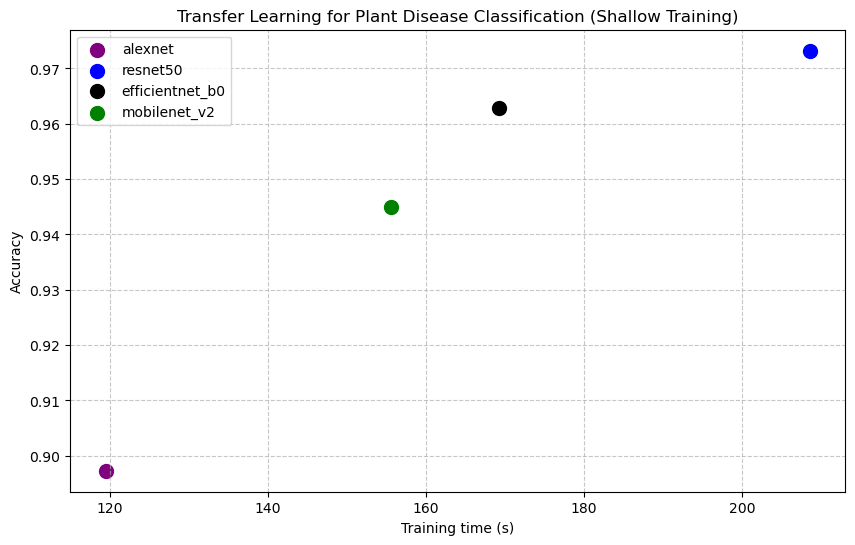

In [ ]:
# Training Time vs. Accuracy (Scatter Plot)
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "D:\\Engineering Works\\Semster - Spring 2025\\AUM\\Graduation Projects\\GP2\\Deep Learning-Based Leaf Image Analysis\\Solution 2\\Code E3\\Results\\shallow_training_results_10_epochs.csv"
df = pd.read_csv(file_path)
print(df.columns)

# Extract data using Pandas column indexing
models = df['Model'].tolist()  # Model names
training_time = df['Training Time (s)'].tolist()  # Training time (in seconds)
accuracy = (df['Accuracy (%)'] / 100).tolist()  # Convert accuracy to decimal format

# Assign colors to models for better visualization
colors = {
    "alexnet": "purple",
    "resnet50": "blue",
    #"squeezenet1_1": "red",
    "efficientnet": "orange",
    "mobilenet_v2": "green"
}

# Define marker style
marker_style = "o"  # Circle marker for shallow training

# Plot each model with its corresponding color
plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    plt.scatter(training_time[i], accuracy[i], color=colors.get(model, "black"),
                marker=marker_style, s=100, label=model if model not in plt.gca().get_legend_handles_labels()[1] else "")

# Labels and title
plt.xlabel("Training time (s)")
plt.ylabel("Accuracy")
plt.title("Transfer Learning for Plant Disease Classification (Shallow Training)")
plt.grid(True, linestyle="--", alpha=0.7)  # Enable grid with dashed lines and transparency

# Show legend for models
plt.legend()
plt.show()


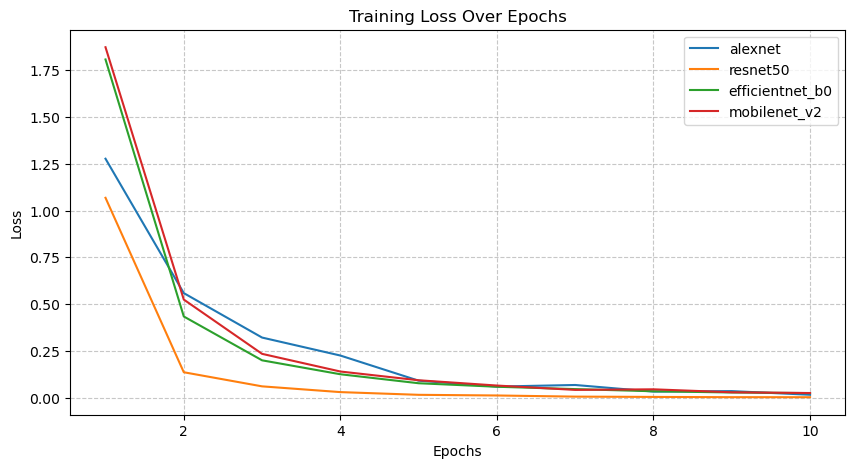

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Convert training losses from semicolon-separated strings to lists of floats
df["Epoch Losses"] = df["Epoch Losses"].apply(lambda x: list(map(float, x.split(";"))))

# Extract relevant data
models = df["Model"].tolist()
train_losses = df["Epoch Losses"].tolist()

### Accuracy & Loss Curves Over Epochs
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses[0]) + 1)

for i, model in enumerate(models):
    plt.plot(epochs, train_losses[i], label=model)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


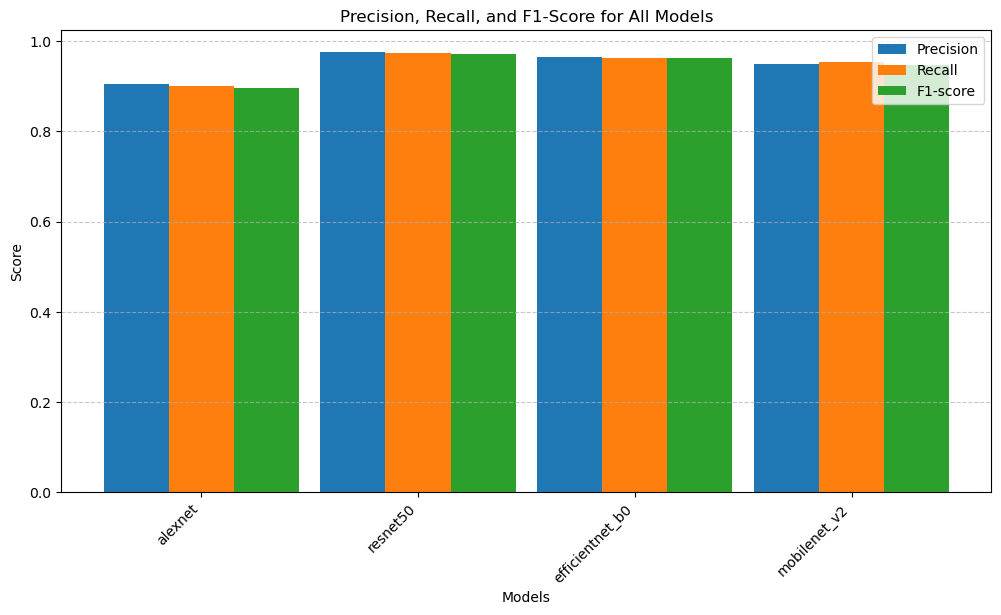

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Extract relevant data
models = df["Model"].tolist()
precision = df["Precision"].tolist()
recall = df["Recall"].tolist()
f1_score = df["F1-Score"].tolist()

# Create x-axis positions for models
x = np.arange(len(models))
width = 0.3  # Bar width

# Plot Precision, Recall, and F1-score for all models
plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-score')

# Customize x-axis labels
plt.xticks(x, models, rotation=45, ha="right")
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for All Models')
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show the plot
plt.show()


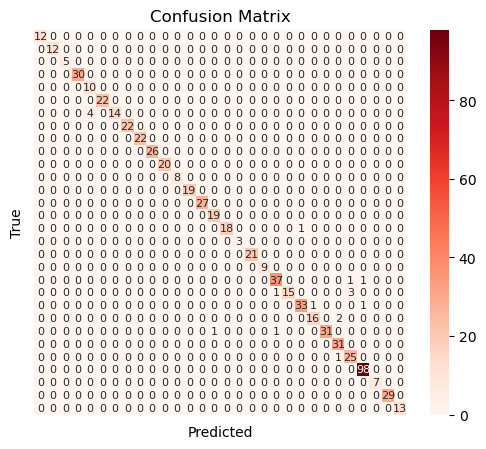

Total samples: 672
Confusion matrix sum: 672
Unique true labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
Unique predicted labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
Incorrect predictions: 18 out of 672


In [ ]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torchvision import transforms, datasets, models  # Ensure models is imported

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Load your test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def remove_module_prefix(state_dict):
    """Removes 'module.' prefix from keys in a state_dict"""
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # Remove 'module.' from key names
        new_state_dict[new_key] = value
    return new_state_dict


# Load dataset
data_dir = 'D:\\Engineering Works\\Semster - Spring 2025\\AUM\\Graduation Projects\\GP2\\Deep Learning-Based Leaf Image Analysis\\Solution 2\\Code E3\\PlantVillage\\test'

test_dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = test_dataset.classes  # Example: ['Healthy', 'Diseased']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define function to load model and get predictions
def evaluate_model(model_path, model, device):
    state_dict = torch.load(model_path, map_location=device)  # Load state dict
    state_dict = remove_module_prefix(state_dict)  # Fix keys if needed

    # Load the modified model (matching num_classes)
    model.load_state_dict(state_dict, strict=False)  # strict=False allows size changes
    model.to(device)
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    return y_true, y_pred



# Load ResNet50 model without pretraining
model = models.resnet50(weights=None)  # Explicitly set weights to None


# Adjust the last FC layer to match the saved model (30 classes)
num_classes = 30  # Change this based on your saved model
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load and evaluate the model
model_path = "D:\\Engineering Works\\Semster - Spring 2025\\AUM\\Graduation Projects\\GP2\\Deep Learning-Based Leaf Image Analysis\\Solution 2\\Code E3\\retrained_models\\resnet50_retrained.pth"
  # Change path accordingly
y_true, y_pred = evaluate_model(model_path, model,device)

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Compute Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Save results into a DataFrame
df_results = pd.DataFrame({
    "y_true": [y_true],
    "y_pred": [y_pred],
    "precision": [precision.tolist()],
    "recall": [recall.tolist()],
    "f1_score": [f1_score.tolist()]
})


# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=False, yticklabels=False)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=False, yticklabels=False, annot_kws={"size": 8})

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print("Total samples:", len(y_true))
print("Confusion matrix sum:", cm.sum())
print("Unique true labels:", set(y_true))
print("Unique predicted labels:", set(y_pred))
incorrect = sum(1 for true, pred in zip(y_true, y_pred) if true != pred)
print(f"Incorrect predictions: {incorrect} out of {len(y_true)}")


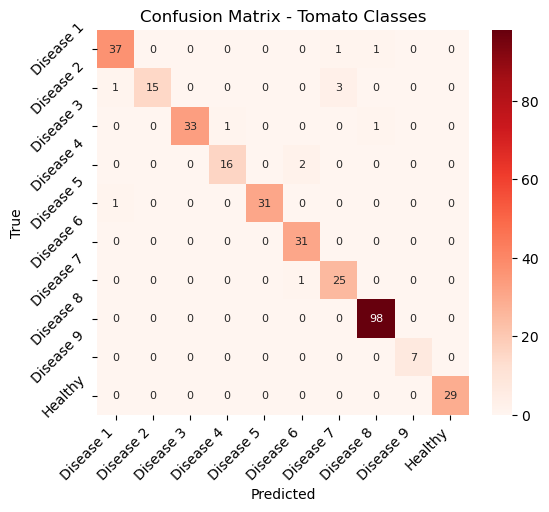

Total tomato samples: 335
Confusion matrix sum (tomato only): 334
Unique true tomato labels: {19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
Unique predicted tomato labels: {14, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
Incorrect tomato predictions: 13 out of 335


In [ ]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the tomato classes
tomato_classes = [cls for cls in class_names if "tomato" in cls.lower()]
tomato_indices = [class_names.index(cls) for cls in tomato_classes]

# Filter the confusion matrix
cm_tomato = cm[np.ix_(tomato_indices, tomato_indices)]

# Generate short class names like "Healthy", "Disease 1", "Disease 2", etc.
short_tomato_classes = ["Healthy" if "healthy" in cls.lower() else f"Disease {i+1}" for i, cls in enumerate(tomato_classes)]

# Plot Confusion Matrix with Simplified Names
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tomato, annot=True, fmt='d', cmap='Reds', xticklabels=short_tomato_classes, yticklabels=short_tomato_classes, annot_kws={"size": 8})

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Tomato Classes")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.show()
# Filter only the samples corresponding to tomato classes
tomato_mask = [label in tomato_indices for label in y_true]

# Extract true and predicted labels for tomato samples
y_true_tomato = [y for y, mask in zip(y_true, tomato_mask) if mask]
y_pred_tomato = [y for y, mask in zip(y_pred, tomato_mask) if mask]

# Compute total samples and incorrect predictions for tomato classes
total_tomato_samples = len(y_true_tomato)
incorrect_tomato = sum(1 for true, pred in zip(y_true_tomato, y_pred_tomato) if true != pred)

# Display results
print("Total tomato samples:", total_tomato_samples)
print("Confusion matrix sum (tomato only):", cm_tomato.sum())
print("Unique true tomato labels:", set(y_true_tomato))
print("Unique predicted tomato labels:", set(y_pred_tomato))
print(f"Incorrect tomato predictions: {incorrect_tomato} out of {total_tomato_samples}")


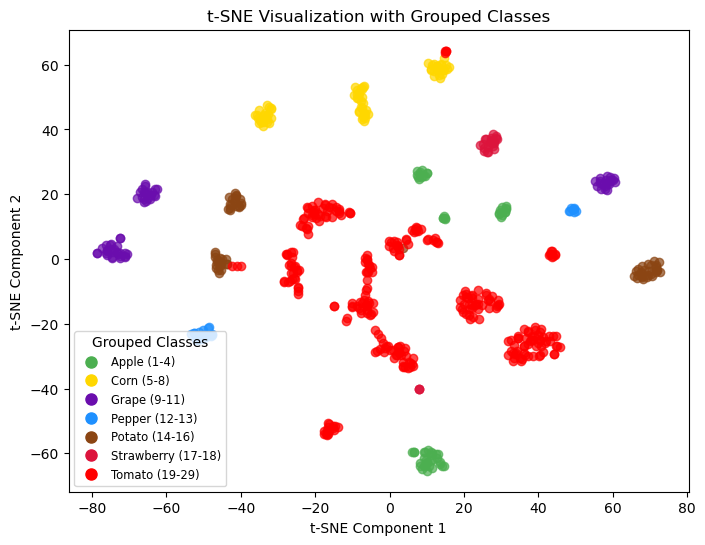

In [ ]:
from sklearn.manifold import TSNE
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch

warnings.filterwarnings("ignore", category=FutureWarning)

# Ensure test_loader is defined before running
if 'test_loader' not in locals():
    raise NameError("test_loader is not defined. Please load the test dataset first.")

# Define class groups
class_groups = {
    "Apple": range(0, 4),  # Class 0-3
    "Corn": range(4, 8),   # Class 4-7
    "Grape": range(8, 11), # Class 8-10
    "Pepper": range(11, 13),  # Class 11-12
    "Potato": range(13, 16),  # Class 13-15
    "Strawberry": range(16, 18),  # Class 16-17
    "Tomato": range(18, 27),  # Class 18-26
    "Background": [27]  # Class 27
}

# Extract feature embeddings from the model (using the penultimate layer)
def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Remove last FC layer to get embeddings
            model_feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last FC layer
            extracted_features = model_feature_extractor(inputs)

            # Flatten and store features & labels
            features.append(extracted_features.view(inputs.size(0), -1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return np.vstack(features), np.array(labels)

# Extract features from the model
features, labels = extract_features(model, test_loader, device)

# Run t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=10, random_state=42)  # Lower perplexity speeds up computation
transformed_features = tsne.fit_transform(features)

# Ensure grouped_labels has the same length as labels
group_mapping = {label: key for key, values in class_groups.items() for label in values}
grouped_labels = np.array([group_mapping.get(label, "Unknown") for label in labels])

# Ensure correct alignment
assert len(grouped_labels) == len(transformed_features), "Mismatch between grouped_labels and transformed_features!"

# Assign unique colors for each group
unique_groups = list(class_groups.keys())
# Define distinct colors for each category
category_colors = {
    "Apple": "#4CAF50",       # Apple Green
    "Corn": "#FFD700",        # Corn Yellow
    "Grape": "#6A0DAD",       # Grape Purple
    "Pepper": "#1E90FF",      # Dodger Blue
    "Potato": "#8B4513",      # Potato Brown
    "Strawberry": "#DC143C",  # Strawberry Red
    "Tomato": "#FF0000",      # Tomato Red
    "Background": "#808080"   # Gray for Background
}
colors = [category_colors[group] for group in unique_groups]  # Assign fixed colors


# Plot t-SNE visualization

plt.figure(figsize=(8, 6))
for i, group in enumerate(unique_groups):
    if group == "Background":
        continue  # Skip Background class
    indices = grouped_labels == group
    plt.scatter(transformed_features[indices, 0], transformed_features[indices, 1], label=group, alpha=0.7, color=colors[i])

# Define legend labels with class ranges
legend_labels = [
    "Apple (1-4)", "Corn (5-8)", "Grape (9-11)", "Pepper (12-13)",
    "Potato (14-16)", "Strawberry (17-18)", "Tomato (19-29)", "Background (30)"
]


# Create legend with class ranges
handles = [plt.Line2D([0], [0], marker='o', color=colors[i], markersize=8, linestyle="None") for i in range(len(unique_groups))]
plt.legend([plt.Line2D([0], [0], marker='o', color=colors[i], markersize=8, linestyle="None")
            for i, group in enumerate(unique_groups) if group != "Background"],
           [label for label in legend_labels if "Background" not in label],
           title="Grouped Classes", loc="lower left", fontsize='small')


#plt.colorbar(label='Class Group')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization with Grouped Classes")
plt.show()


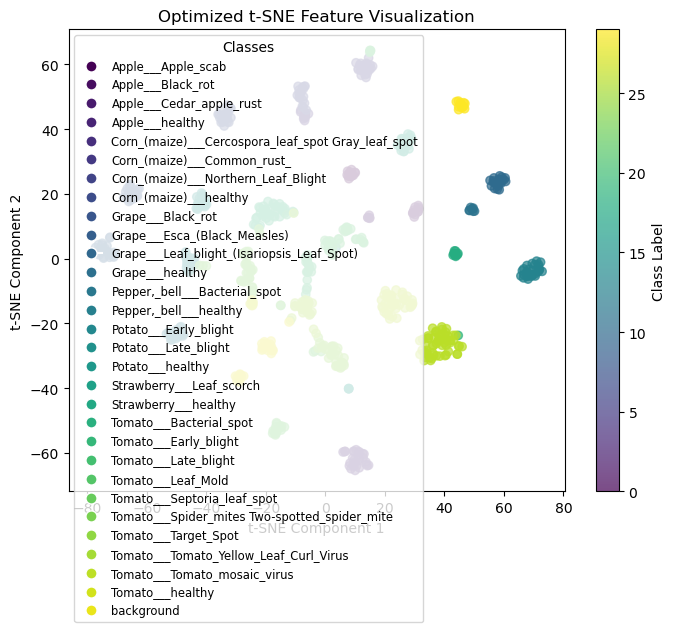

In [ ]:
# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
# Add legend labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=plt.cm.viridis(i / len(class_names))) for i in range(len(class_names))]
plt.legend(handles, class_names, title="Classes", loc="best", fontsize='small')

plt.colorbar(label='Class Label')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Optimized t-SNE Feature Visualization")
plt.show()